Try fitting the NUV with everything on the best example (GJ676A)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ676A/'
os.listdir(path)

['hlsp_muscles_hst_cos_gj676a_g130m_v24_component-spec.fits',
 'hlsp_muscles_hst_stis_gj676a_g140l_v24_component-spec.fits',
 'hlsp_muscles_hst_stis_gj676a_g140m_v24_component-spec.fits',
 'hlsp_muscles_hst_stis_gj676a_g230l_v24_component-spec.fits',
 'hlsp_muscles_hst_stis_gj676a_g430l_v24_component-spec.fits',
 'hlsp_muscles_model_apec_gj676a_na_v24_component-spec.fits',
 'hlsp_muscles_model_euv-scaling_gj676a_na_v24_component-spec.fits',
 'hlsp_muscles_model_lya-reconstruction_gj676a_na_v24_component-spec.fits',
 'hlsp_muscles_model_phx_gj676a_na_v24_component-spec.fits',
 'hlsp_muscles_multi_multi_gj676a_broadband_v24_adapt-const-res-sed.fits',
 'hlsp_muscles_multi_multi_gj676a_broadband_v24_adapt-var-res-sed.fits',
 'hlsp_muscles_multi_multi_gj676a_broadband_v24_const-res-sed.fits',
 'hlsp_muscles_multi_multi_gj676a_broadband_v24_var-res-sed.fits']

In [8]:
ndata = fits.getdata(glob.glob('{}*g230*'.format(path))[0], 1)
odata = fits.getdata(glob.glob('{}*g430*'.format(path))[0], 1)
pdata = fits.getdata(glob.glob('{}*phx*'.format(path))[0], 1)

nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
norm = fits.getheader(glob.glob('{}*phx*'.format(path))[0], 0)['NORMFAC']
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX']*norm, pdata['ERROR']*norm


In [84]:
for i in range(len(ne)):
    if ne[i] == 0:
        ne[i] = np.median(ne)

In [10]:
import prepare_phoenix_svo as pp


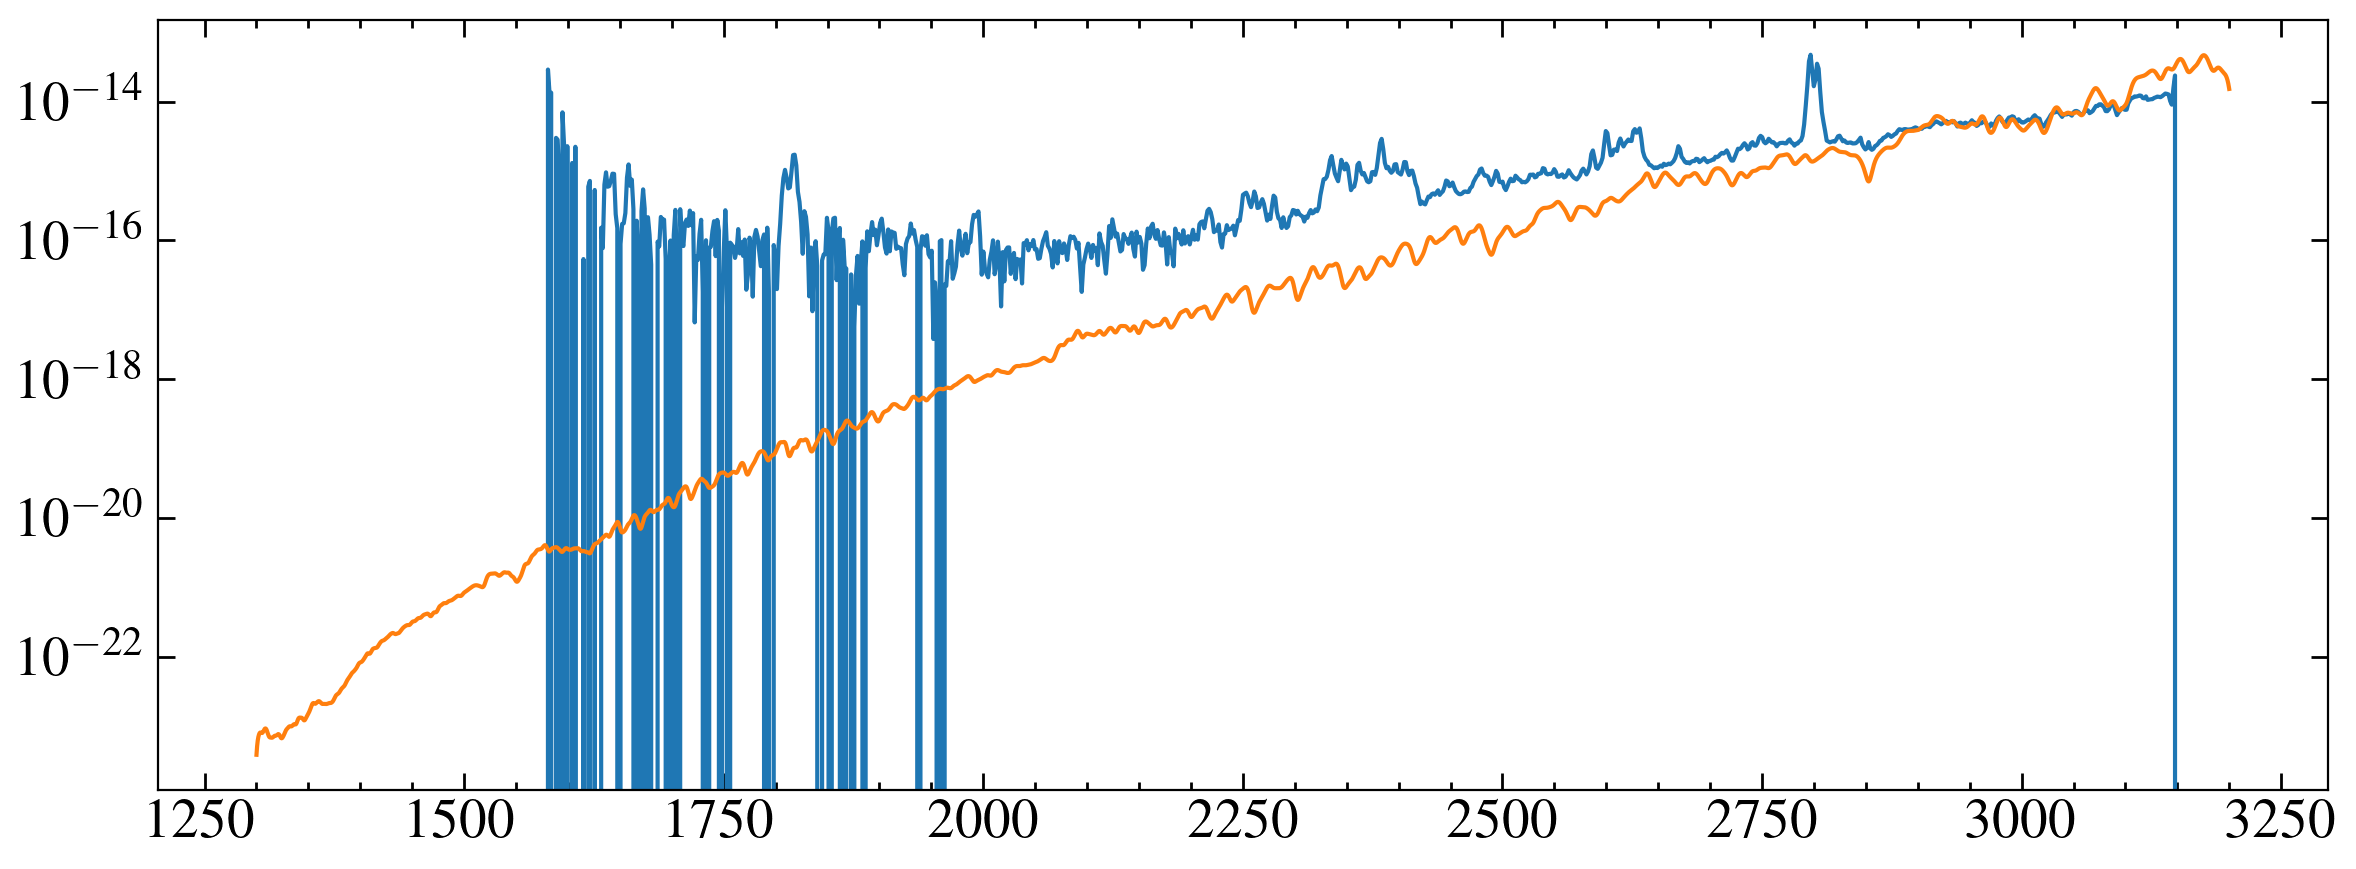

In [14]:
pmask = (pw > 1300) & (pw < 3200)
pwi, pfi = pw[pmask], pf[pmask]
pwi, pfi = pp.smear(pwi, pfi, 1000)

plt.plot(nw, nf)
# plt.plot(ow, of)
# pmask = (pw > 1700) & (pw < 5000)
# plt.plot(pw[pmask], pf[pmask])
plt.plot(pwi, pfi)
plt.yscale('log')

What are the emission lines - iron?

(2780.0, 2820.0)

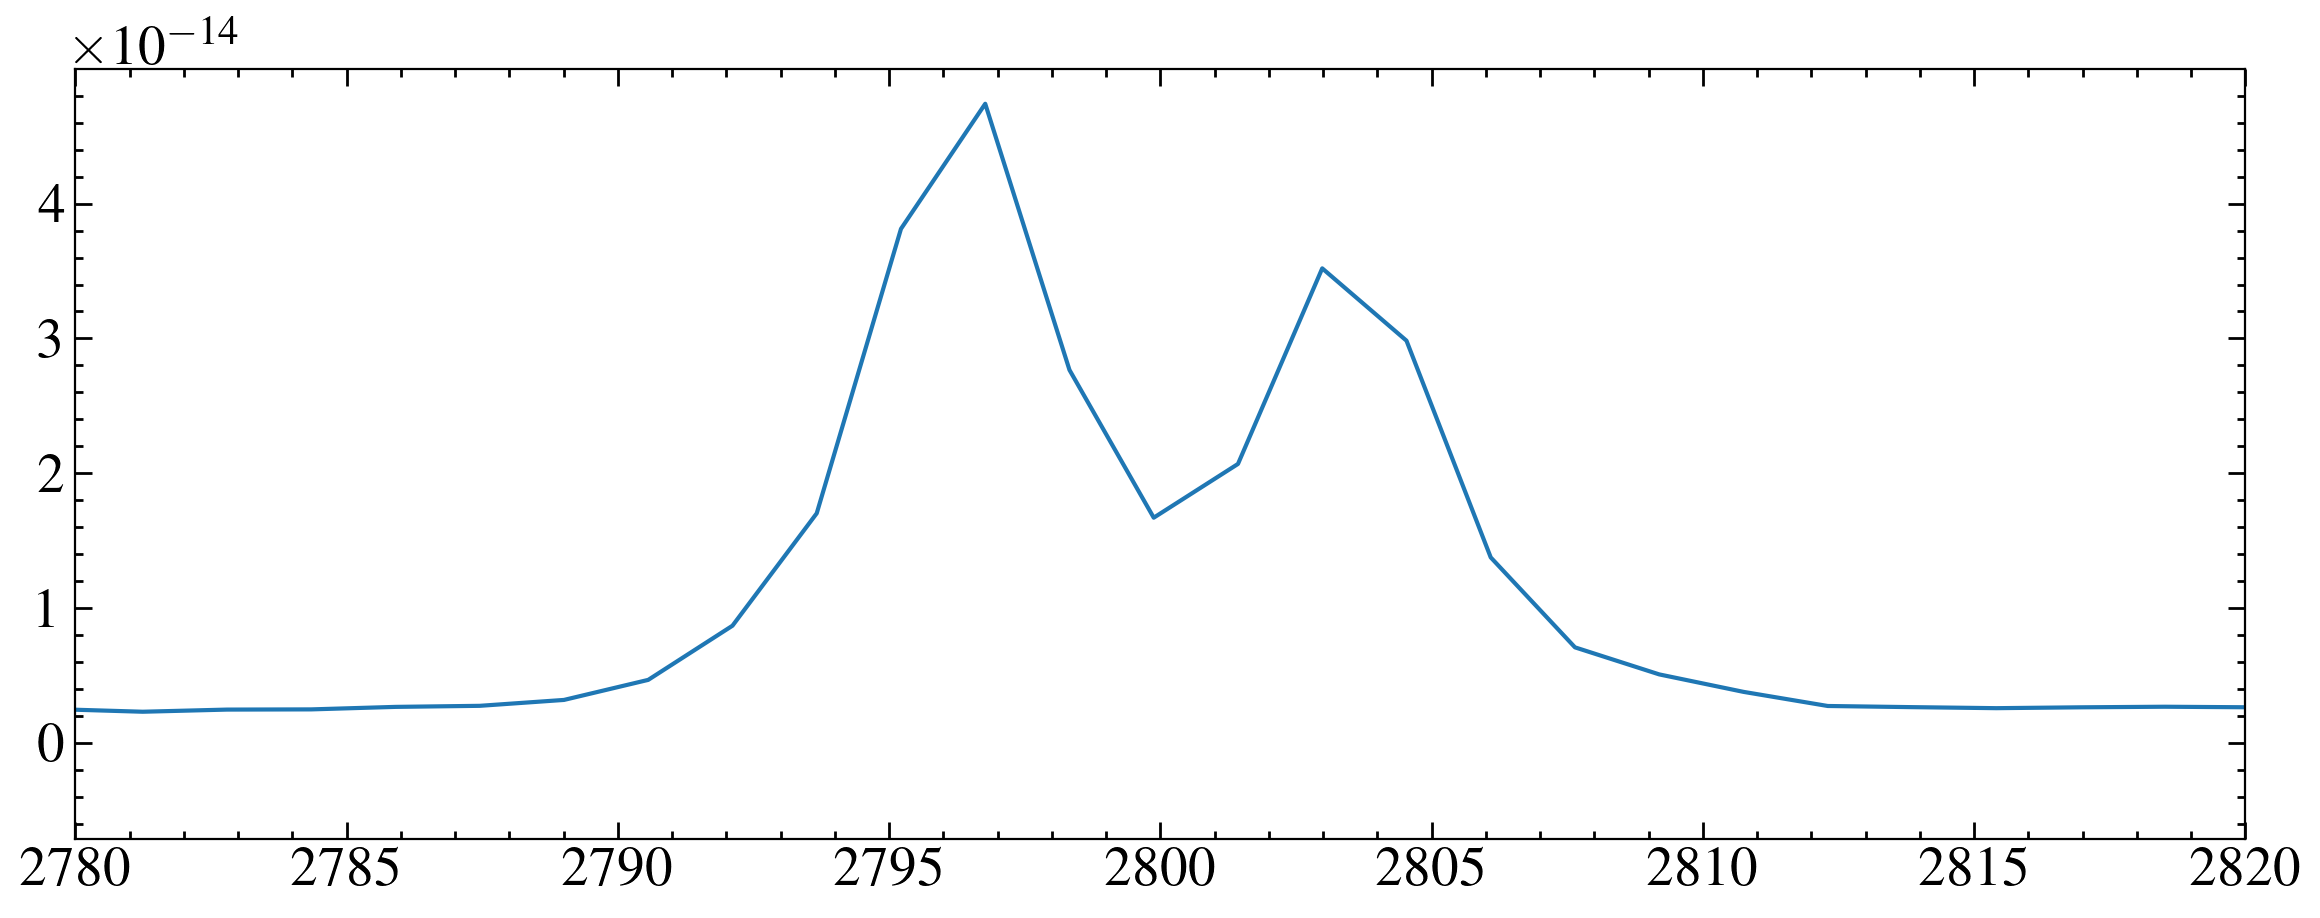

In [24]:
plt.plot(nw, nf)

mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

# c2 = [232.423, 232.543 ,232.6121,232.768 ,232.886]
# [plt.axvline(line*10, ls='--', c='C2', alpha=0.5) for line in c2]
plt.xlim(2780, 2820)
# plt.ylim(0, 1e-14)
# plt.yscale('log')

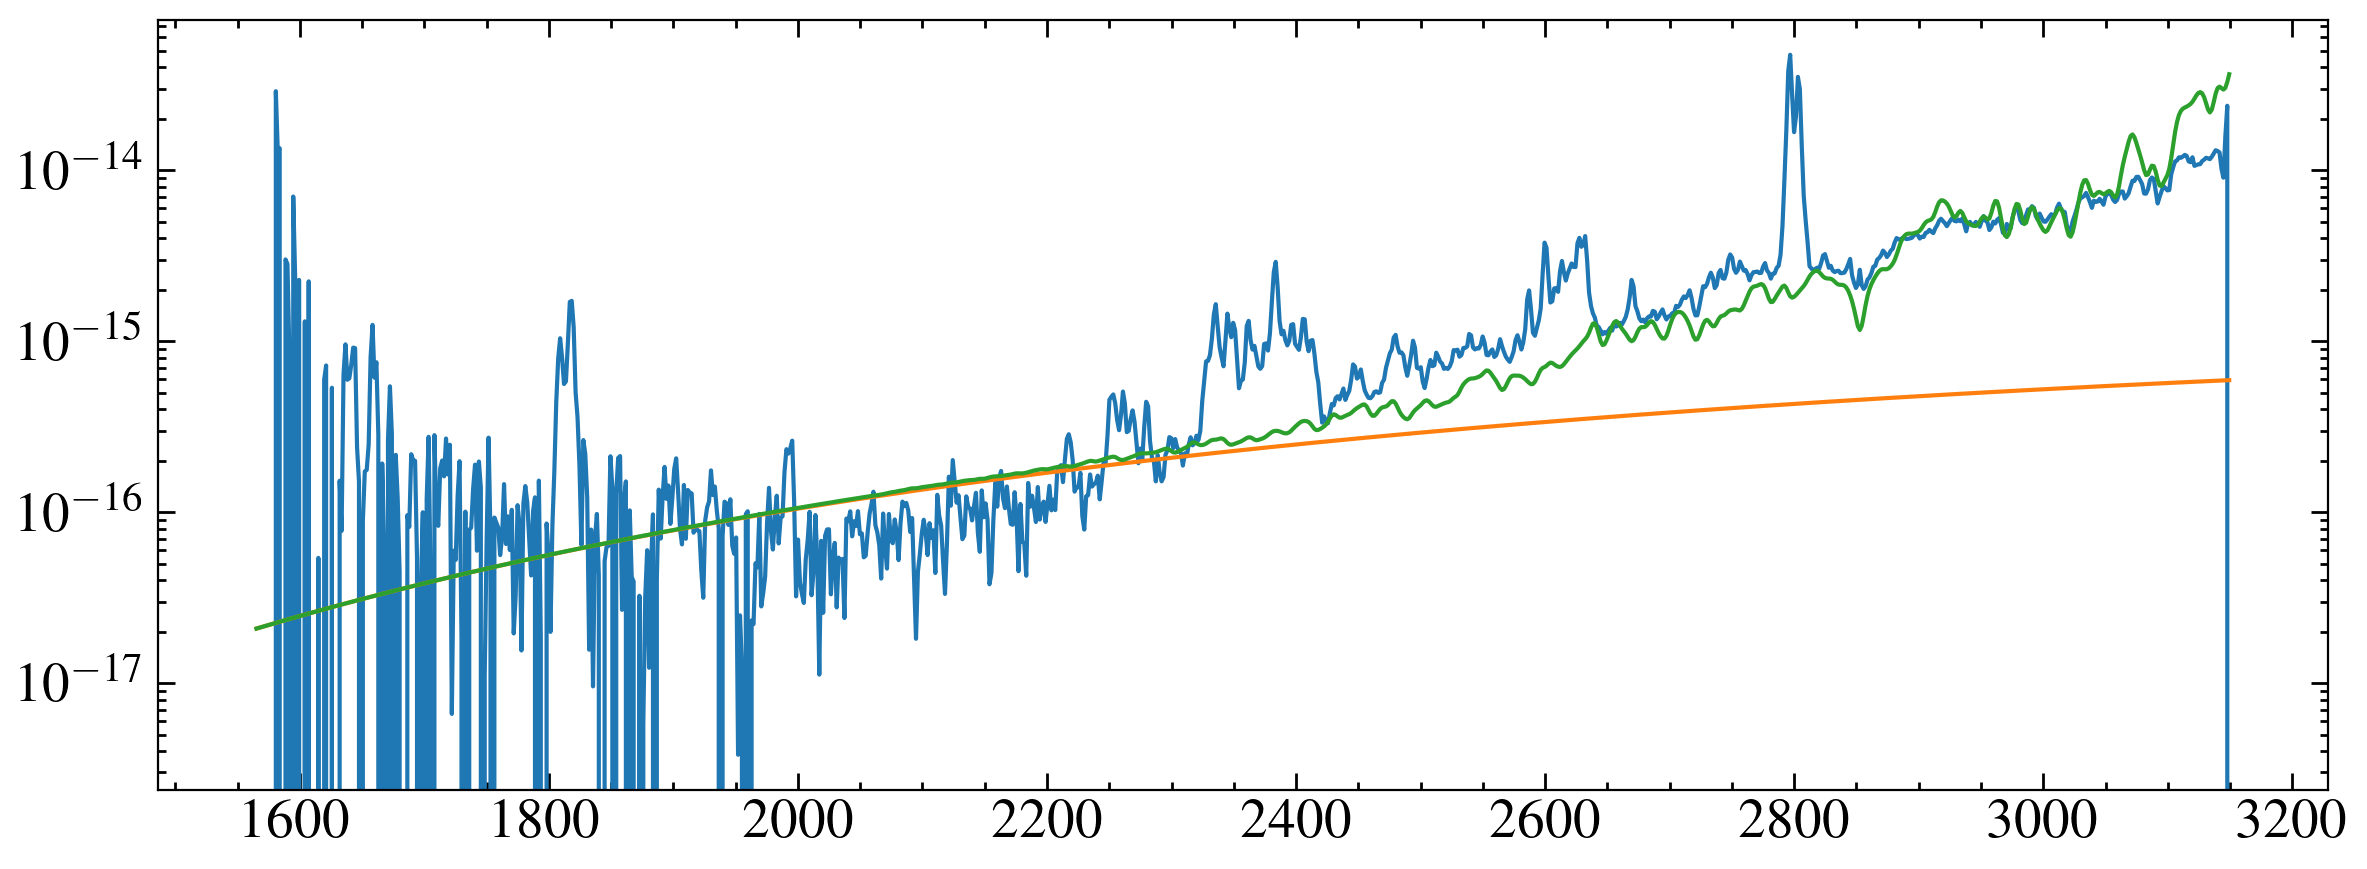

In [65]:
bb = models.BlackBody(temperature=8500*u.K, fixed=dict(temperature=True))
plt.plot(nw, nf)
fb = bb(nw*u.AA)

pfb = interp1d(pwi, pfi, fill_value='extrapolate')(nw)

scale= 1e-11
plt.plot(nw, fb*scale)
plt.plot(nw, (fb*scale).value+pfb)
plt.yscale('log')

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
    ----------------- ---------------------
    4728.641585043812 8.664438316442614e-21


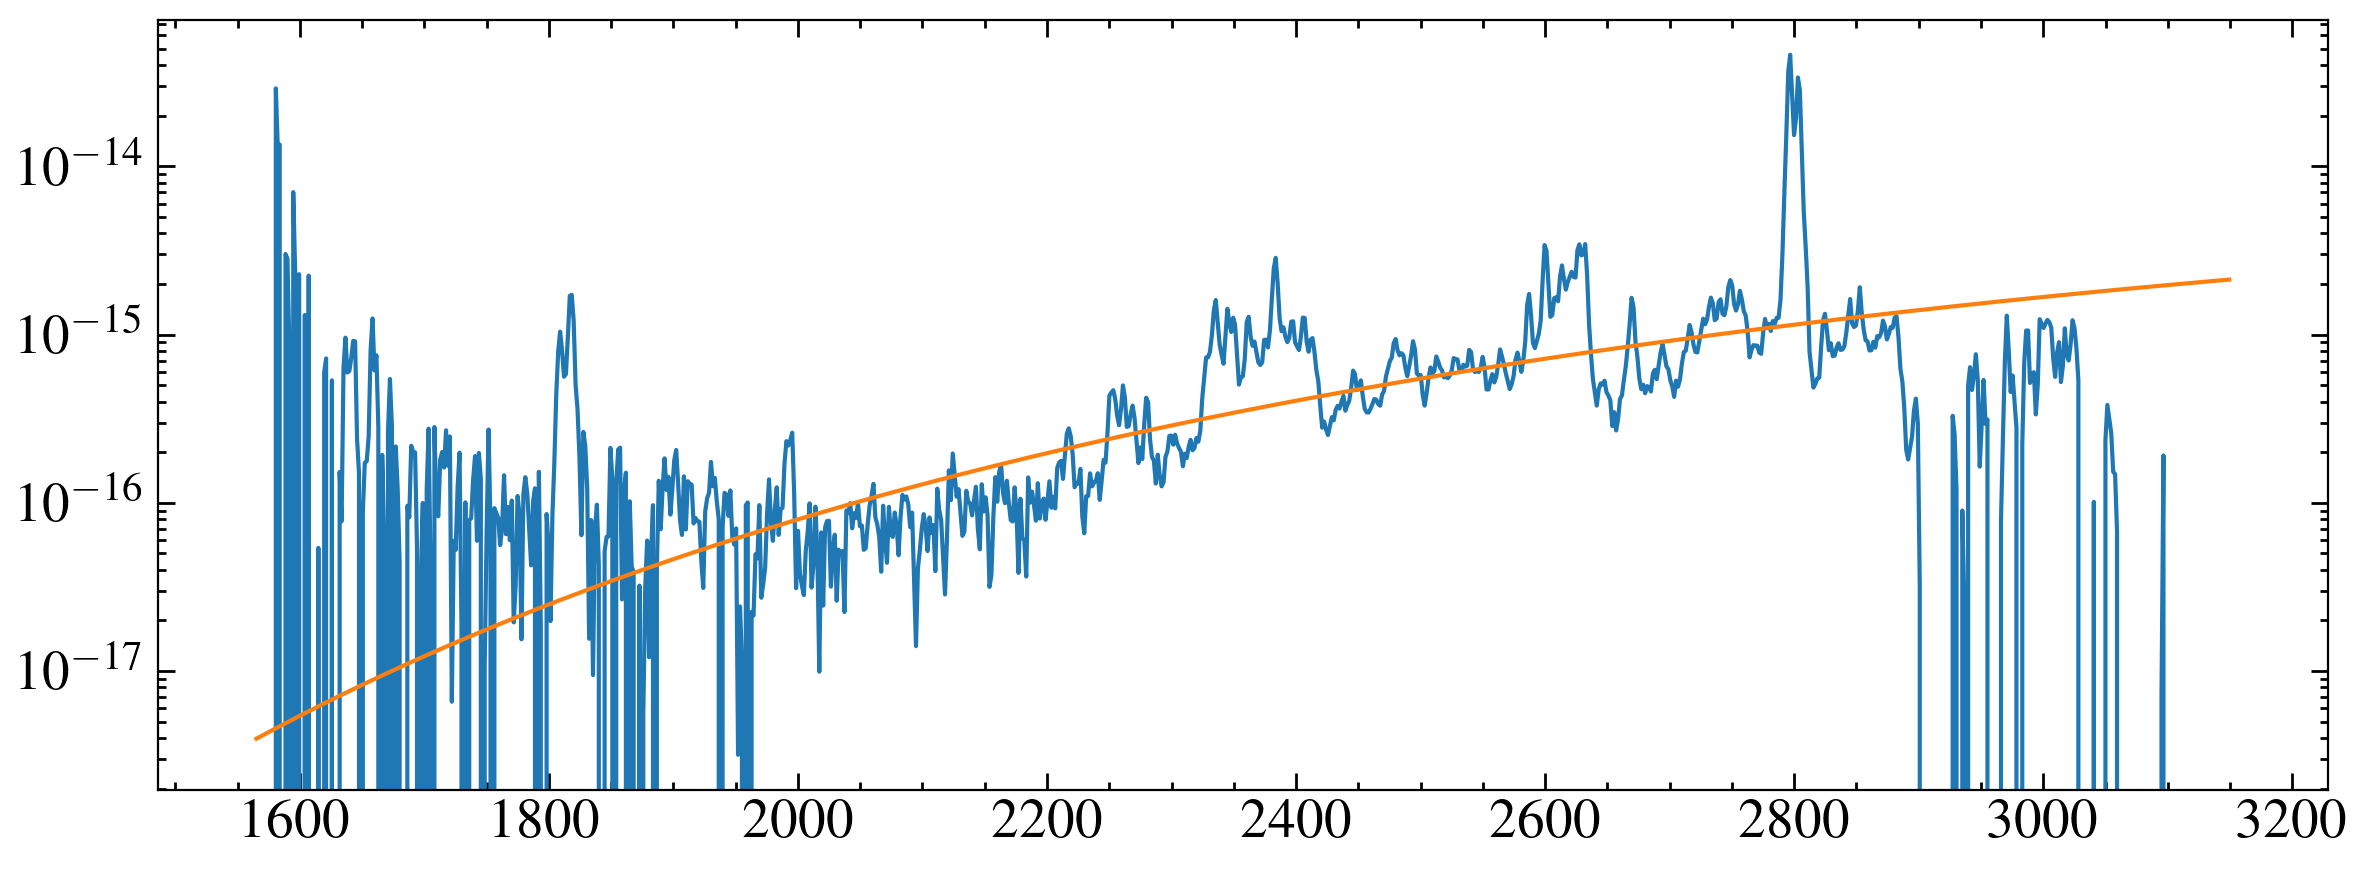

In [99]:
fitter = fitting.LevMarLSQFitter()

bb_init = models.BlackBody(temperature=20000*u.K, scale=1e-22*u.erg/u.s/u.cm**2/u.AA/u.sr)

nfb = nf -pfb

plt.plot(nw, nfb)
# plt.plot(nw, fb*scale)

# mask = (nw > 2000) & ( nw <2320) | (nw > 2420) & (nw < 2580) | ( nw > 2650) #& (nw < 2790) | (nw> 2810) #mask out lines
mask = (nw > 1700) & (nw < 1800) | (nw > 1850) & ( nw <2320) | (nw > 2420) & (nw < 2580) | ( nw > 2650) #& (nw < 2790) | (nw> 2810) #mask out lines

bb_fit = fitter(bb_init, nw[mask], nfb[mask], weights = 1/ne[mask]**2, maxiter=10000)

print(bb_fit)

fb = bb_fit(nw)
plt.plot(nw, fb)

plt.yscale('log')

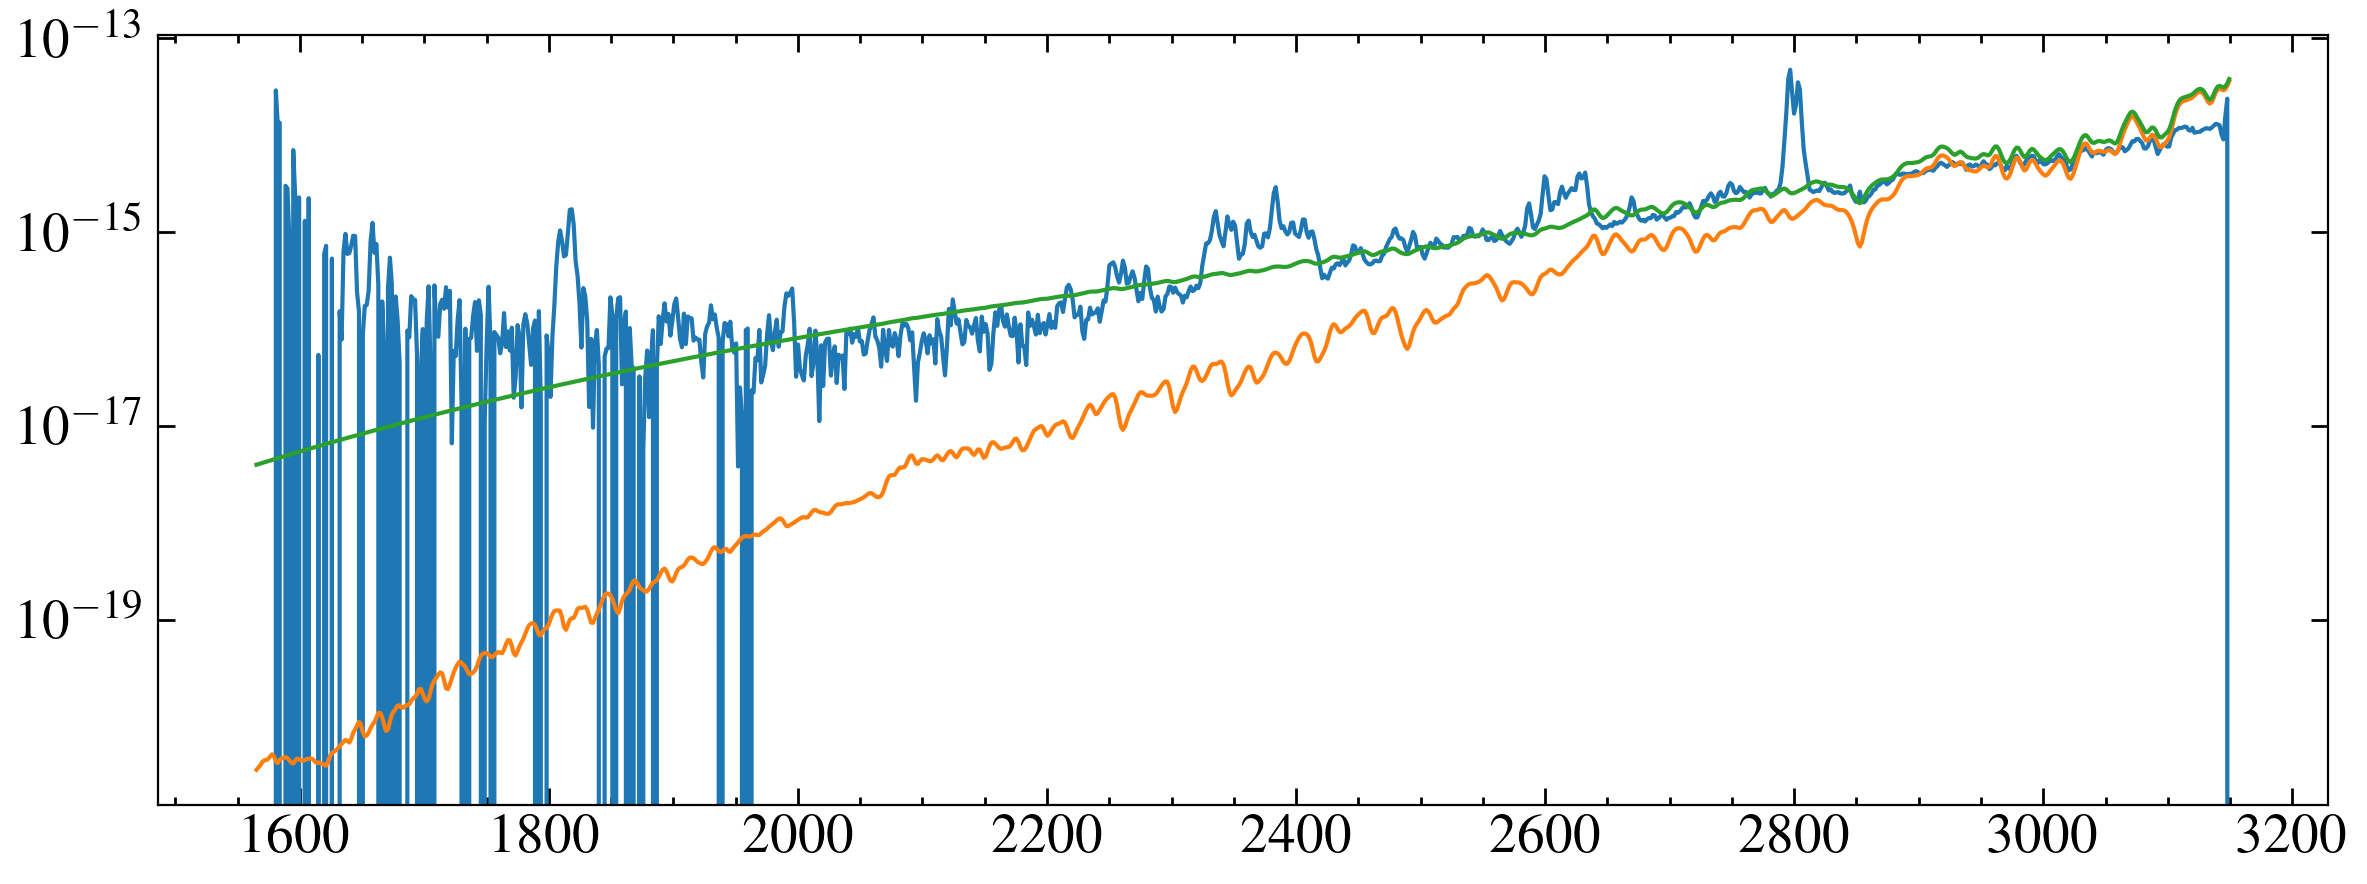

In [100]:
plt.plot(nw, nf)
plt.plot(nw, pfb)

plt.plot(nw, pfb+fb)
plt.yscale('log')

In [104]:
sed = fits.getdata(glob.glob('{}*multi_multi_gj676a_broadband_v24_adapt-const-res-sed*'.format(path))[0], 1)

sw, sf, se = sed['WAVELENGTH'], sed['FLUX'], sed['ERROR']

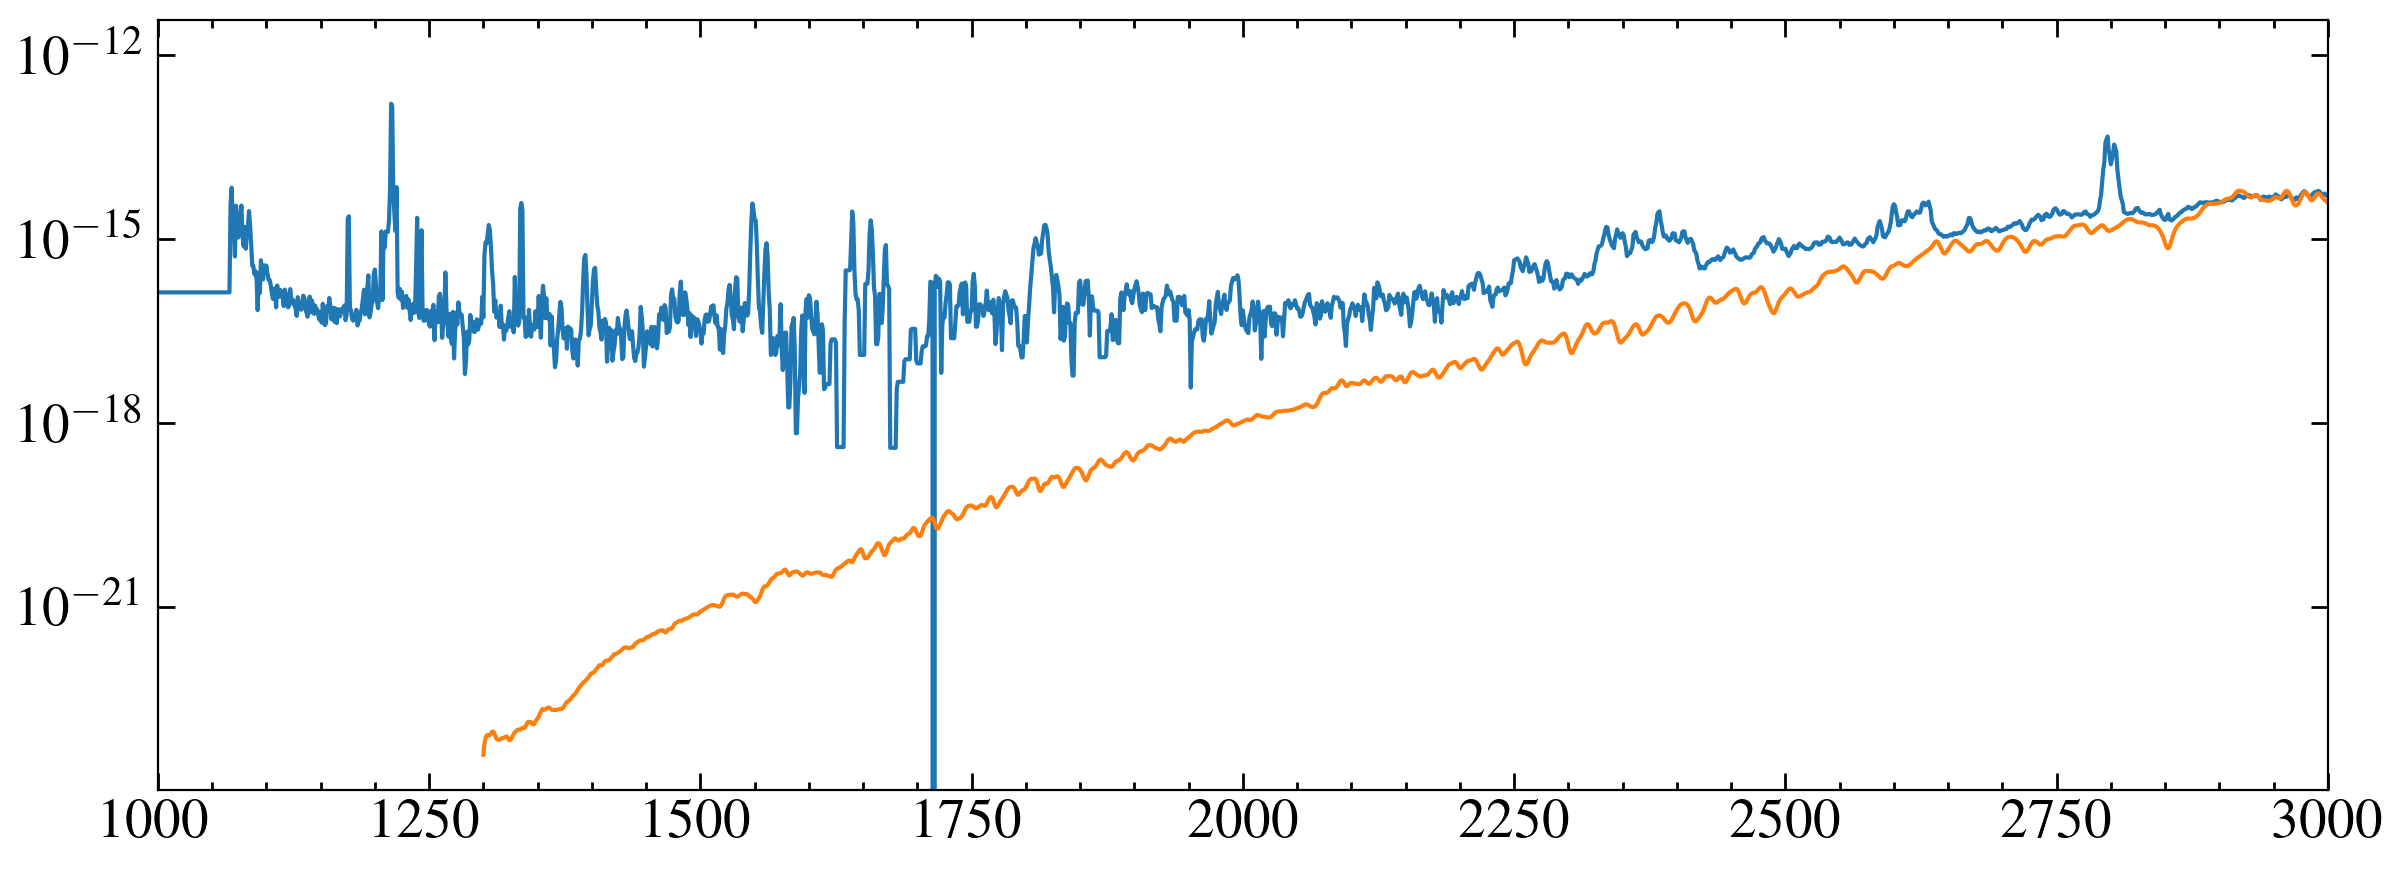

In [114]:
plt.plot(sw, sf)
fbp = bb(pwi)
plt.plot(pwi, pfi+fbp.value)

plt.xlim(1000, 3000)
plt.yscale('log')